In [12]:
import json
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("data")

files = {
    "warm": DATA_DIR / "k6_fargate_warm.json",
    "mixed": DATA_DIR / "k6_fargate_mixed.json",
    "cold": DATA_DIR / "k6_fargate_cold.json",
}

files


{'warm': PosixPath('data/k6_fargate_warm.json'),
 'mixed': PosixPath('data/k6_fargate_mixed.json'),
 'cold': PosixPath('data/k6_fargate_cold.json')}

In [8]:
def load_k6_linejson(path: Path):
    """Load k6 newline JSON file and return a list of http_req_duration values in ms."""
    vals = []
    if not path.exists():
        # if a test wasn't run yet, just return empty
        return vals
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            # same logic has been used for both lambda and fargate analysis 
            if obj.get("type") == "Point" and obj.get("metric") == "http_req_duration":
                vals.append(obj["data"]["value"])
    return vals


In [9]:
data = {name: load_k6_linejson(path) for name, path in files.items()}

for name, vals in data.items():
    print(f"{name}: {len(vals)} samples")


warm: 150 samples
mixed: 150 samples
cold: 0 samples


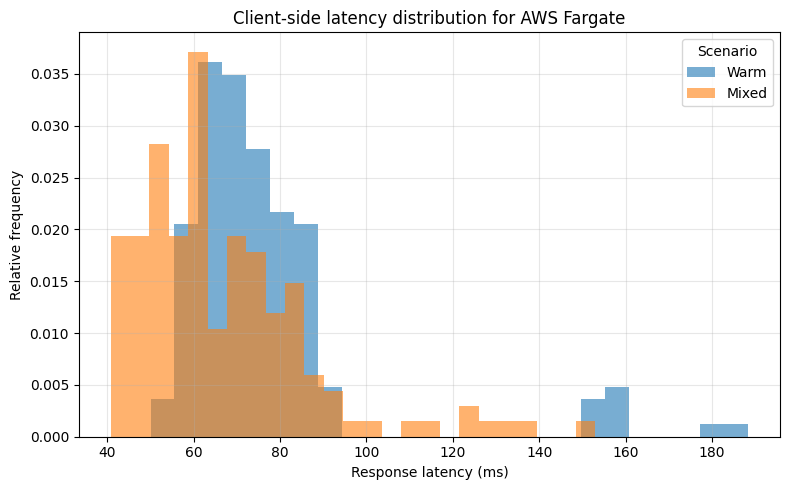

In [13]:
plt.figure(figsize=(8, 5))

# Plot histograms for each scenario if data exists
for name, vals in data.items():
    if vals:
        plt.hist(
            vals,
            bins=25,
            alpha=0.6,
            label=name.capitalize(),  # Warm, Mixed, Cold
            density=True,              # normalize so areas are comparable
        )

plt.xlabel("Response latency (ms)")
plt.ylabel("Relative frequency")
plt.title("Client-side latency distribution for AWS Fargate")
plt.legend(title="Scenario")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
rows = []
for name, vals in data.items():
    if not vals:
        rows.append({
            "scenario": name,
            "count": 0,
            "avg_ms": None,
            "p50_ms": None,
            "p90_ms": None,
            "p95_ms": None,
            "max_ms": None,
        })
    else:
        s = pd.Series(vals)
        rows.append({
            "scenario": name,
            "count": len(s),
            "avg_ms": s.mean(),
            "p50_ms": np.percentile(s, 50),
            "p90_ms": np.percentile(s, 90),
            "p95_ms": np.percentile(s, 95),
            "max_ms": s.max(),
        })

df_fargate = pd.DataFrame(rows).set_index("scenario")
df_fargate


,count,avg_ms,p50_ms,p90_ms,p95_ms,max_ms
scenario,,,,,,
warm,150,77.229740,71.6740,86.7321,151.65265,188.340
mixed,150,66.723127,61.8365,86.5366,105.12385,152.932
cold,0,NaN,NaN,NaN,NaN,NaN


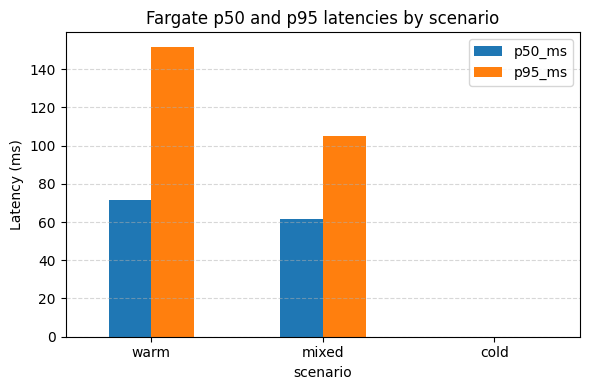

In [5]:
ax = df_fargate[["p50_ms", "p95_ms"]].plot.bar(rot=0, figsize=(6, 4))
ax.set_ylabel("Latency (ms)")
ax.set_title("Fargate p50 and p95 latencies by scenario")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [6]:
df.to_csv(DATA_DIR / "lambda_summary.csv", index_label="scenario")


NameError: name 'df' is not defined

In [10]:
out_path = DATA_DIR / "fargate_summary.csv"
df_fargate.to_csv(out_path, index_label="scenario")
out_path


PosixPath('data/fargate_summary.csv')